In [17]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel('Account Summary.xlsx')
df

,Date,Day,Adjusted_Gross&Sales,Net_Sales,HST,Counted_Cash,Foreign_Cash&Equiv.,Total_Cash,Debit,Tims_Gift_Card&Redeem,...,Scan_and_Pay&Amex,Scan_and_Pay&Timcard,Digital_Visa,Digital_Mastercard,Digital_AMEX,Digital_Tims&Gift Card,Rebates,Tims_Gift_Card&Load,Deposit,Over_ /_Short
0,2022-01-01,Sat,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
1,2022-01-02,Sun,1081.13,1060.40,89.41,437.00,0.00,437.00,452.24,175.05,...,0,0,4.03,11.80,0.0,3.95,0.00,25.0,1189.31,14.50
2,2022-01-03,Mon,1919.92,1868.58,147.47,785.65,0.00,785.65,699.54,311.70,...,0,0,0.00,0.00,0.0,0.00,0.00,0.0,1992.17,-23.88
3,2022-01-04,Tue,2540.98,2435.94,188.05,1004.80,0.00,1004.80,850.72,508.46,...,0,0,2.30,0.00,0.0,0.00,0.00,0.0,2570.93,-0.06
4,2022-01-05,Wed,2562.88,2464.21,206.06,1057.75,0.00,1057.75,783.30,478.72,...,0,0,4.11,8.50,0.0,5.79,0.00,8.4,2682.02,3.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022-12-27,Tue,1998.74,1931.15,167.50,716.10,0.00,716.10,783.97,292.75,...,0,59,2.07,0.00,0.0,0.00,0.22,132.8,2206.79,-24.88
361,2022-12-28,Wed,2186.97,2118.68,174.66,878.35,2.54,880.89,788.39,392.27,...,3,34,0.00,2.07,0.0,6.70,0.12,65.0,2360.28,1.82
362,2022-12-29,Thu,2205.63,2152.85,185.05,960.30,0.00,960.30,747.71,334.89,...,1,37,0.00,0.00,0.0,0.00,0.29,10.0,2342.30,-5.89
363,2022-12-30,Fri,2107.68,2043.40,175.29,873.60,0.00,873.60,774.92,354.04,...,0,38,0.00,0.00,0.0,0.00,0.05,0.0,2213.73,-5.01


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [4]:
target = 'Net_Sales'
data = df[[target]]

In [5]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

In [6]:
# Sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # Using past 10 days for prediction
X, y = create_sequences(data_scaled, seq_length)

In [7]:
# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
#LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.3160 - val_loss: 0.0766
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0337 - val_loss: 0.0298
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0215 - val_loss: 0.0299
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0208 - val_loss: 0.0297
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0204 - val_loss: 0.0304
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208 - val_loss: 0.0306
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0194 - val_loss: 0.0296
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0216 - val_loss: 0.0335
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0192 - val_loss: 0.0301
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0190 - val_loss: 0.0298
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0212 - val_loss: 0.0307
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.

In [10]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


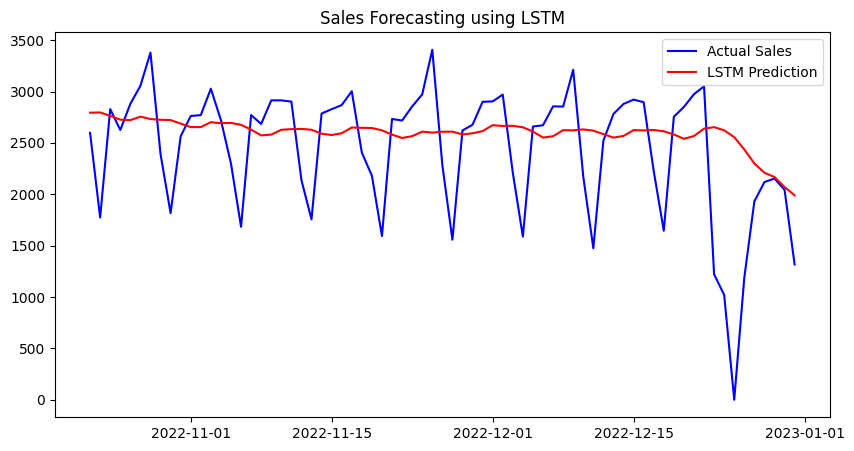

In [11]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label='Actual Sales', color='blue')
plt.plot(df.index[-len(y_test):], y_pred_rescaled, label='LSTM Prediction', color='red')
plt.legend()
plt.title('Sales Forecasting using LSTM')
plt.show()

## Feature Engineering

In [12]:
# Extract date-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Day_of_Week'] = df.index.weekday

df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
df['Quarter'] = df.index.quarter

df['Rolling_Mean_7'] = df['Net_Sales'].rolling(window=7).mean()
df['Rolling_Mean_14'] = df['Net_Sales'].rolling(window=14).mean()
df.fillna(method='bfill', inplace=True)

In [13]:
# Lag features
df['Lag_1'] = df['Net_Sales'].shift(1)
df['Lag_7'] = df['Net_Sales'].shift(7)

df.fillna(method='bfill', inplace=True)

## Feature Selection

In [14]:
# Select features for ML models
features = ['Year', 'Month', 'Day', 'Day_of_Week', 'Is_Weekend', 'Quarter', 'Rolling_Mean_7', 'Rolling_Mean_14']
target = 'Net_Sales'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [15]:
# Normalize the features for LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM
X_train_LSTM = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_LSTM = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [18]:
# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Train LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_LSTM.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_LSTM, y_train_scaled, epochs=20, batch_size=16, validation_data=(X_test_LSTM, y_test_scaled))

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.3209 - val_loss: 0.1214
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0865 - val_loss: 0.0532
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0554 - val_loss: 0.0376
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0477 - val_loss: 0.0333
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0403 - val_loss: 0.0311
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0321 - val_loss: 0.0297
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0323 - val_loss: 0.0274
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0304 - val_loss: 0.0267
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0273 - val_loss: 0.0257
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0255 - val_loss: 0.0260
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0254 - val_loss: 0.0310
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [19]:
# Make LSTM predictions
y_pred_lstm = lstm_model.predict(X_test_LSTM)
y_pred_lstm_rescaled = scaler_y.inverse_transform(y_pred_lstm)

# Evaluate both models
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

mae_lstm = mean_absolute_error(y_test, y_pred_lstm_rescaled)
mse_lstm = mean_squared_error(y_test, y_pred_lstm_rescaled)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm_rescaled)

print(f"XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R2 Score: {r2_xgb}")
print(f"LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}, R2 Score: {r2_lstm}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
XGBoost - MAE: 154.5825137120077, RMSE: 261.6553412825748, R2 Score: 0.7915756500741995
LSTM - MAE: 419.5919359348245, RMSE: 558.1738567716833, R2 Score: 0.05151988672548724


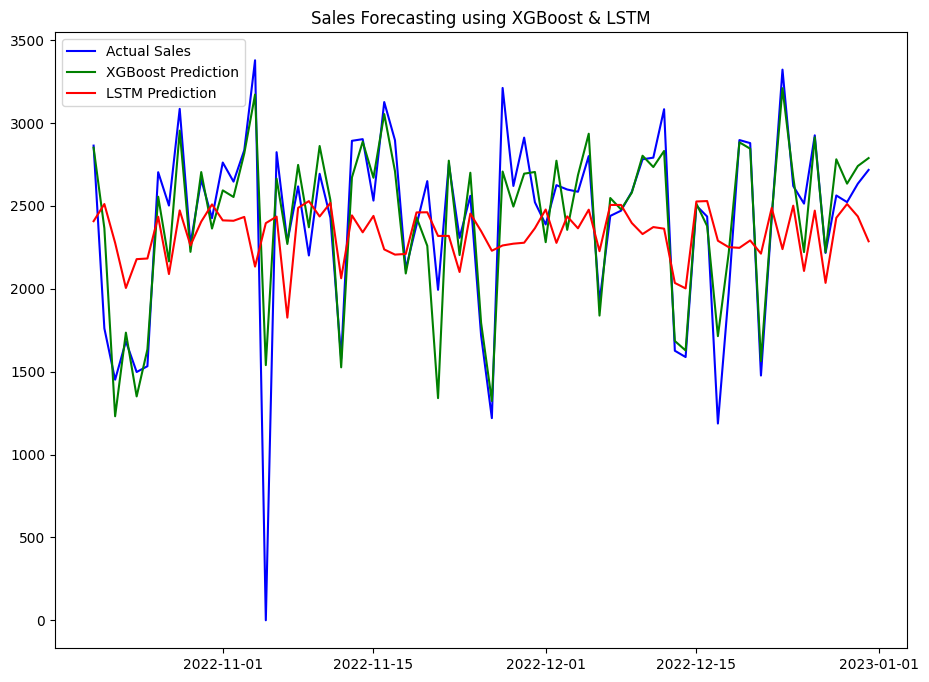

In [23]:
# Plot predictions
plt.figure(figsize=(11, 8))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Sales', color='blue')
plt.plot(df.index[-len(y_test):], y_pred_xgb, label='XGBoost Prediction', color='green')
plt.plot(df.index[-len(y_test):], y_pred_lstm_rescaled, label='LSTM Prediction', color='red')
plt.legend()
plt.title('Sales Forecasting using XGBoost & LSTM')
plt.show()